# Linear regression with early stopping using Laplacian random features

In [1]:
import matplotlib.pyplot as plt
import torch
from torchmetrics.classification import MulticlassAccuracy, MulticlassCalibrationError
from utils import load_fmnist
from tqdm.notebook import trange
import torch.nn.functional as F
from torchkernels.feature_maps import LaplacianRFF

In [2]:
DEVICE = torch.device('cpu')
X_train, X_test, y_train, y_test = load_fmnist(device=DEVICE)
n, d = X_train.shape
c = len(y_train.unique())
y_train_onehot = F.one_hot(y_train, num_classes=c).float()
y_test_onehot = F.one_hot(y_test, num_classes=c).float()

### Define random feature map

In [3]:
p = 1024 # number of random features
feature_map = LaplacianRFF(input_dim=d, num_features=p, device = DEVICE)

### Training Setup

In [4]:
criterion = torch.nn.MSELoss()
acc = MulticlassAccuracy(num_classes=c)
ece = MulticlassCalibrationError(num_classes=c)

w = torch.zeros(p, c, requires_grad=True)
optimizer = torch.optim.Adam([w], lr=0.003)

epochs = 20
batch_size = 512
step=0
train_loss, train_acc, train_ece = [], [], []
test_steps, test_loss, test_acc, test_ece = [], [], [], []
softmax_ = torch.nn.Softmax(dim=1)

### Training iterations

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

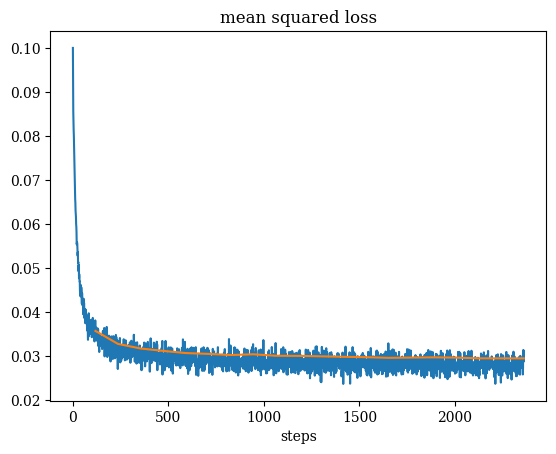

In [5]:
for _ in trange(epochs, desc='epochs'):
  indices = torch.randperm(n)  # Shuffle indices
  
  for i in range(0, n, batch_size):
    batch_indices = indices[i:i+batch_size]
    X_batch, y_batch_onehot, y_batch = X_train[batch_indices], y_train_onehot[batch_indices], y_train[batch_indices]
    
    yhat_batch = feature_map(X_batch) @ w
    loss = criterion(yhat_batch, y_batch_onehot)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step+=1
    
    # track train metrics every batch
    with torch.no_grad():
      train_loss.append(loss.item())
      train_acc.append(acc(yhat_batch, y_batch))
      train_ece.append(ece(softmax_(yhat_batch), y_batch))

  # track test metrics every epoch
  with torch.no_grad():
    yhat_test = feature_map(X_test) @ w
    test_steps.append(step)
    test_loss.append(criterion(yhat_test, y_test_onehot))
    test_acc.append(acc(yhat_test, y_test))
    test_ece.append(ece(yhat_test, y_test))

plt.title('mean squared loss')
plt.xlabel('steps')
plt.plot(train_loss, label='train')
_=plt.plot(test_steps, test_loss, label='test')

## Metrics

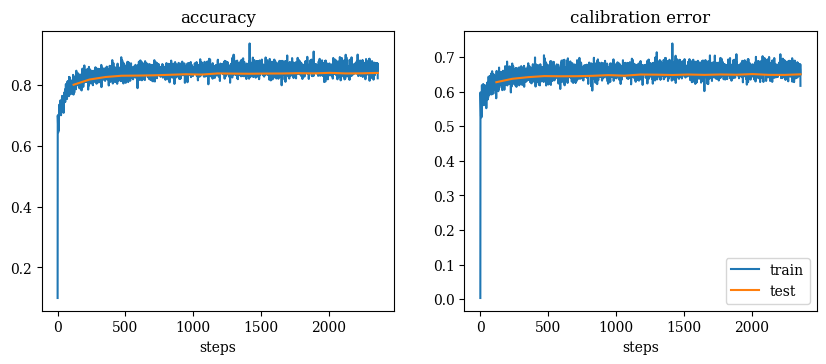

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('accuracy')
plt.plot(train_acc, label='train')
plt.plot(test_steps, test_acc, label='test')
plt.xlabel('steps')
plt.subplot(2,2,2)
plt.title('calibration error')
plt.plot(train_ece, label='train')
plt.plot(test_steps, test_ece, label='test')
plt.xlabel('steps')
_=plt.legend()